In [11]:
import numpy as np
import pandas as pd
from sklearn import *
import tensorflow as tf
import matplotlib.pyplot as plt

In [40]:
import requests
url = "https://raw.githubusercontent.com/abulbasar/machine-learning/master/Utils.py"
exec(requests.get(url).text)

In [4]:
df_train = pd.read_csv("/data/MNIST/mnist_train.csv")
df_test = pd.read_csv("/data/MNIST/mnist_test.csv")

In [198]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(df_train.iloc[:, 1:])
X_test = scaler.fit_transform(df_test.iloc[:, 1:])
y_train = df_train.iloc[:, 0]
y_test = df_test.iloc[:, 0]

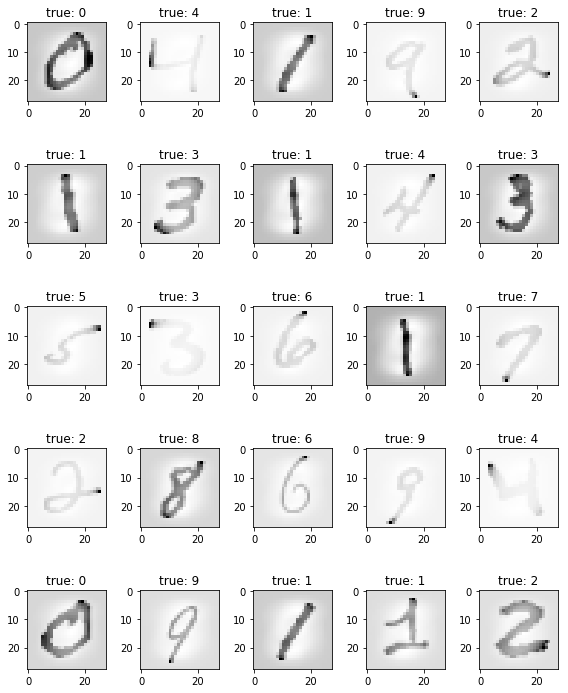

In [14]:
fig, _ = plt.subplots(5, 5, figsize = (8, 10))

for i, ax in enumerate(fig.axes):
    X = X_train[i].reshape(28, 28)
    label = df_train.iloc[i, 0]
    ax.imshow(X, cmap="Greys")
    ax.set_title("true: " + str(label))
    
plt.tight_layout()

2.30258 0.117188
0.351321 0.921875
0.249366 0.945312
0.280942 0.90625
0.260796 0.898438
0.144964 0.945312
0.276592 0.90625
0.250066 0.929688
0.520211 0.90625
0.282757 0.921875
0.25882 0.9375
Test accuracy [0.92169219]


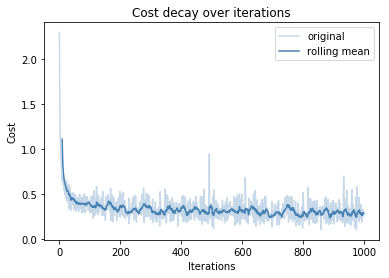

In [78]:
n_x = 784
n_y = 10
n_h = 400
max_iters = 1000

tf.reset_default_graph()
tf.set_random_seed(1)

learning_rate = 1e-01

X =tf.placeholder(dtype=tf.float32, shape = [None, n_x])
y =tf.placeholder(dtype=tf.int32, shape = [None])

y_oh =tf.one_hot(indices = y, depth = n_y)

W = tf.Variable(tf.zeros([n_x, n_y]))
b = tf.Variable(tf.zeros([n_y]))

Z = tf.matmul(X, W) + b

y_pred = tf.cast(tf.arg_max(Z, 1),tf.int32)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y, y_pred), tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_oh, logits = Z))

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

scores = {}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    batchable = Batchable(X = X_train, y = y_train.values, batch_size=128)
    
    for i in range(max_iters):
        X_batch, y_batch = batchable.next()
        _,cost_, accuracy_ = sess.run([optimizer, cost, accuracy], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
    
        if i % (max_iters // 10) == 0 or i == max_iters - 1:
            print(cost_, accuracy_)
    
    accuracy_ = sess.run([accuracy], feed_dict={X: X_test, y: y_test})
    print("Test accuracy", accuracy_)
    
    plot_scores(scores)

3.65357 0.0625
0.582783 0.859375
0.470603 0.859375
0.255154 0.921875
0.259244 0.953125
0.393332 0.875
2.21338 0.890625
0.243603 0.953125
0.249156 0.890625
0.306179 0.890625
0.430647 0.90625
Test accuracy [0.91339135]


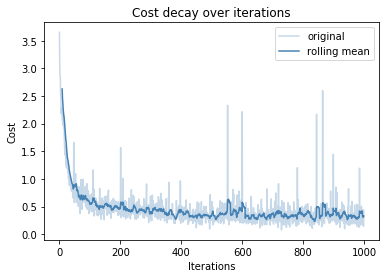

In [95]:
n_x = 784
n_y = 10
n_h = 400
max_iters = 1000

tf.reset_default_graph()
tf.set_random_seed(1)

learning_rate = 1e-03

X =tf.placeholder(dtype=tf.float32, shape = [None, n_x])
y =tf.placeholder(dtype=tf.int32, shape = [None])

y_oh =tf.one_hot(indices = y, depth = n_y)

W = tf.get_variable(name="W", shape=[n_x, n_y], 
                initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.zeros([n_y]))

Z = tf.matmul(X, W) + b

y_pred = tf.cast(tf.arg_max(Z, 1),tf.int32)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y, y_pred), tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_oh, logits = Z))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

scores = {}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    batchable = Batchable(X = X_train, y = y_train.values, batch_size=64)
    
    for i in range(max_iters):
        X_batch, y_batch = batchable.next()
        _,cost_, accuracy_ = sess.run([optimizer, cost, accuracy], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
    
        if i % (max_iters // 10) == 0 or i == max_iters - 1:
            print(cost_, accuracy_)
    
    accuracy_ = sess.run([accuracy], feed_dict={X: X_test, y: y_test})
    print("Test accuracy", accuracy_)
    
    plot_scores(scores)

3.4292 0.0546875
1.01097 0.859375
0.329524 0.890625
1.04956 0.851562
0.302189 0.882812
0.180723 0.960938
0.284301 0.90625
0.243699 0.929688
0.544013 0.898438
0.296252 0.9375
0.260363 0.929688
Test accuracy [0.91739172]


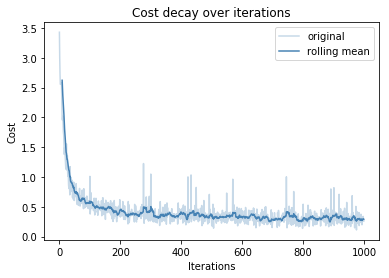

In [99]:
n_x = 784
n_y = 10
n_h = 400
max_iters = 1000

tf.reset_default_graph()
tf.set_random_seed(1)

learning_rate = 1e-03

X =tf.placeholder(dtype=tf.float32, shape = [None, n_x])
y =tf.placeholder(dtype=tf.int32, shape = [None])

y_oh =tf.one_hot(indices = y, depth = n_y)

def full_layer(input, size, activation = None):
    input_size = int(input.get_shape()[1])
    W = tf.get_variable(name="W", shape=[input_size, size], 
                initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.zeros([n_y]))
    Z = tf.matmul(X, W) + b
    return Z

Z = full_layer(X, 10)

y_pred = tf.cast(tf.arg_max(Z, 1),tf.int32)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y, y_pred), tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_oh, logits = Z))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

scores = {}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    batchable = Batchable(X = X_train, y = y_train.values, batch_size=128)
    
    for i in range(max_iters):
        X_batch, y_batch = batchable.next()
        _,cost_, accuracy_ = sess.run([optimizer, cost, accuracy], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
    
        if i % (max_iters // 10) == 0 or i == max_iters - 1:
            print(cost_, accuracy_)
    
    accuracy_ = sess.run([accuracy], feed_dict={X: X_test, y: y_test})
    print("Test accuracy", accuracy_)
    
    plot_scores(scores)

2.45864 0.109375
0.626171 0.789062
0.286475 0.898438
0.246375 0.914062
0.229102 0.914062
0.180933 0.9375
0.110066 0.976562
0.183202 0.914062
0.27989 0.929688
0.176316 0.921875
0.14363 0.929688
Test accuracy [0.96559656]


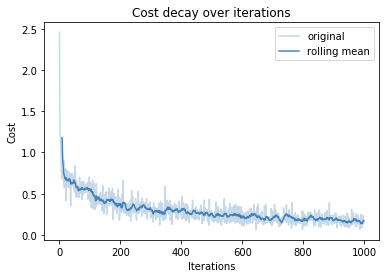

In [124]:
n_x = 784
n_y = 10
hidden_layers = [400, 400, 400]
max_iters = 1000

tf.reset_default_graph()
tf.set_random_seed(1)

learning_rate = 1e-03

X =tf.placeholder(dtype=tf.float32, shape = [None, n_x])
y =tf.placeholder(dtype=tf.int32, shape = [None])
keep_prob = tf.placeholder_with_default(1.0, shape = [])

y_oh =tf.one_hot(indices = y, depth = n_y)

def full_layer(name, input, size, activation = None):
    input_size = int(input.get_shape()[1])
    W = tf.get_variable(name=name + "_W", shape=[input_size, size], 
                initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.zeros([size]))
    Z = tf.matmul(input, W) + b
    
    if not activation is None:
        Z = activation(Z)
    
    Z = tf.nn.dropout(Z, keep_prob = keep_prob)
    
    return Z

A = X 
for i, size in enumerate(hidden_layers):
    A = full_layer("hidden_" + str(i), A, size, tf.nn.tanh)
    
Z = full_layer("FC_last", A, n_y)

y_pred = tf.cast(tf.arg_max(Z, 1),tf.int32)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y, y_pred), tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_oh, logits = Z))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

scores = {}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    batchable = Batchable(X = X_train, y = y_train.values, batch_size=128)
    
    for i in range(max_iters):
        X_batch, y_batch = batchable.next()
        _,cost_, accuracy_ = sess.run([optimizer, cost, accuracy], feed_dict={X: X_batch, 
                                                            y: y_batch, keep_prob: 0.9})
        scores[i] = cost_
    
        if i % (max_iters // 10) == 0 or i == max_iters - 1:
            print(cost_, accuracy_)
    
    accuracy_ = sess.run([accuracy], feed_dict={X: X_test, y: y_test})
    print("Test accuracy", accuracy_)
    
    plot_scores(scores)

conv1 Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
pool1 Tensor("MaxPool:0", shape=(?, 28, 28, 32), dtype=float32)
conv2 Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
pool2 Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Total size 3136
full_layer1 Tensor("dropout/mul:0", shape=(?, 400), dtype=float32)
full_layer2 Tensor("dropout_1/mul:0", shape=(?, 10), dtype=float32)
y_pred Tensor("ArgMax:0", shape=(?,), dtype=int32)
0 training cost:  2.30276 training accuracy:  0.132812
50 training cost:  1.13482 training accuracy:  0.609375
100 training cost:  0.910377 training accuracy:  0.695312
150 training cost:  0.904642 training accuracy:  0.679688
200 training cost:  0.642925 training accuracy:  0.75
250 training cost:  0.638968 training accuracy:  0.757812
300 training cost:  0.485032 training accuracy:  0.804688
350 training cost:  0.830825 training accuracy:  0.679688
400 training cost:  0.628142 training accuracy:  0.765625
450 training cost:  0.739819 trai

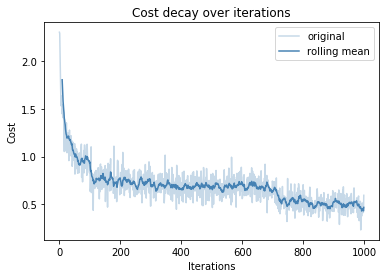

In [199]:
%%%time 
n_x = 784
n_y = 10
n_H, n_W, n_C = 28, 28, 1 
n_h = 400
max_iters = 1000

tf.reset_default_graph()
tf.set_random_seed(1)

learning_rate = 1e-03

X =tf.placeholder(dtype=tf.float32, shape = [None, n_x])
y =tf.placeholder(dtype=tf.int32, shape = [None])
keep_prob = tf.placeholder_with_default(1.0, shape = [])

y_oh =tf.one_hot(indices = y, depth = n_y)
X_image = tf.reshape(X, [-1, n_H, n_W, n_C])

def full_layer(name, input, size, activation = None):
    input_size = int(input.get_shape()[1])
    W = tf.get_variable(name=name + "_W", shape=[input_size, size], 
                initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.zeros([size]))
    Z = tf.matmul(input, W) + b
    
    if not activation is None:
        Z = activation(Z)
    
    Z = tf.nn.dropout(Z, keep_prob = keep_prob)
    
    return Z

def conv_layer(name, input, shape, strides, padding):
    W = tf.get_variable(name + "_W", shape = shape, 
                        initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.zeros([shape[3]]))
    
    A = tf.nn.conv2d(input, W, strides, padding)
    A = tf.nn.relu(A + b)
    
    return A

def pooling_layer(input, ksize, strides, padding = "SAME"):
    A = tf.nn.max_pool(value = input, ksize = ksize, strides = strides, padding = padding)
    return A
    

conv1 = conv_layer("c1", X_image, shape =  [5, 5, 1, 32], strides = [1, 1, 1, 1], padding = "SAME")
print("conv1", conv1)
pool1 = pooling_layer(conv1,ksize=[1, 2, 2, 1],strides= [1, 1, 1, 1], padding="SAME")
print("pool1", pool1)

conv2 = conv_layer("c2", pool1, shape = [5, 5, 32, 64],strides = [1, 2, 2, 1], padding = "SAME")
print("conv2", conv2)
pool2 = pooling_layer(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "VALID")
print("pool2", pool2)


pool2_shape = pool2.get_shape()

total_size = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]
print("Total size", total_size)
flatten = tf.reshape(pool2, [-1, total_size])


full_layer1= full_layer("fc1", flatten, n_h, activation = tf.nn.relu)
print("full_layer1", full_layer1)
full_layer2= full_layer("fc2", full_layer1, n_y, activation = tf.nn.relu)
print("full_layer2", full_layer2)

Z = full_layer2

y_pred = tf.argmax(Z, axis=1, output_type=tf.int32) 
print("y_pred", y_pred)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=Z))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


with tf.Session() as sess:
    scores = {}
    sess.run(tf.global_variables_initializer())
        
    batchable = Batchable(X_train, y_train, batch_size=128)

    for i in range(max_iters):
        X_batch, y_batch = batchable.next()
        accuracy_, cost_, _ = sess.run([accuracy, cost, optimizer]
                        , feed_dict={X: X_batch, y: y_batch, keep_prob: 0.8})
        scores[i] = cost_
        if i % (max_iters // 20) == 0 or i == (max_iters - 1): 
            print(i, "training cost: ", cost_, "training accuracy: ", accuracy_)
            
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test, y: y_test})
    print("Test accuracy: ", accuracy_)
    plot_scores(scores)

    y_test_pred = sess.run(y_pred, feed_dict={X: X_test})



In [170]:
cifar = CifarLoader("/data/cifar-10-batches-py")
cifar

/data/cifar-10-batches-py/data_batch_1
/data/cifar-10-batches-py/data_batch_2
/data/cifar-10-batches-py/data_batch_3
/data/cifar-10-batches-py/data_batch_4
/data/cifar-10-batches-py/data_batch_5
/data/cifar-10-batches-py/test_batch


X_train        (50000, 3072)  
X_test         (10000, 3072)  
y_train        (50000,)       
y_test         (10000,)       
labels         ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

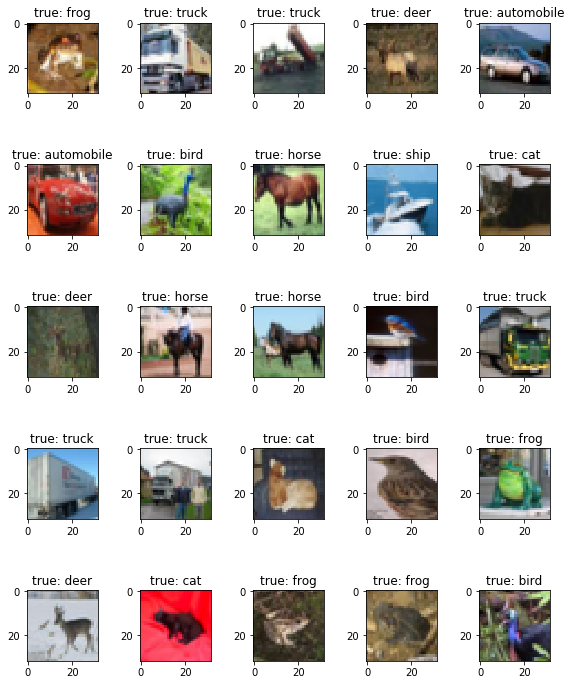

In [206]:
X_train = cifar.X_train
y_train = cifar.y_train
X_test = cifar.X_test
y_test = cifar.y_test

fig, _ = plt.subplots(5, 5, figsize = (8, 10))

for i, ax in enumerate(fig.axes):
    img = X_train[i].reshape(3, 32, 32).transpose(1, 2, 0).astype(np.uint8)
    label = cifar.labels[y_train[i]]
    ax.imshow(img)
    ax.set_title("true: " + str(label))
    
plt.tight_layout()

In [208]:
scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train.astype(np.float32))
X_test_std = scaler.transform(X_test.astype(np.float32))

X_image Tensor("transpose:0", shape=(?, 32, 32, 3), dtype=float32)
conv1 Tensor("Relu:0", shape=(?, 32, 32, 32), dtype=float32)
pool1 Tensor("MaxPool:0", shape=(?, 32, 32, 32), dtype=float32)
conv2 Tensor("Relu_1:0", shape=(?, 16, 16, 64), dtype=float32)
pool2 Tensor("MaxPool_1:0", shape=(?, 8, 8, 64), dtype=float32)
Total size 4096
full_layer1 Tensor("dropout/mul:0", shape=(?, 400), dtype=float32)
full_layer2 Tensor("dropout_1/mul:0", shape=(?, 10), dtype=float32)
y_pred Tensor("ArgMax:0", shape=(?,), dtype=int32)
0 training cost:  2.36485 training batch accuracy:  0.203125 test accuracy 0.1133
200 training cost:  1.95396 training batch accuracy:  0.28125 test accuracy 0.4515
400 training cost:  1.91461 training batch accuracy:  0.265625 test accuracy 0.5006
600 training cost:  1.85118 training batch accuracy:  0.390625 test accuracy 0.5389
800 training cost:  1.79704 training batch accuracy:  0.3125 test accuracy 0.5578
1000 training cost:  1.57507 training batch accuracy:  0.484375 

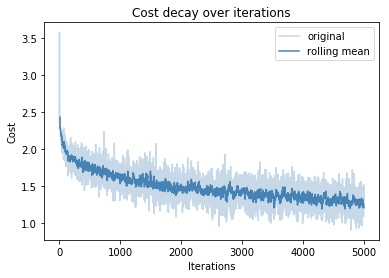

In [215]:
%%%time 
n_x = X_train.shape[1]
n_y = len(cifar.labels)
n_H, n_W, n_C = 32, 32, 3 
n_h = 400
max_iters = 5000

tf.reset_default_graph()
tf.set_random_seed(1)

learning_rate = 1e-03

X =tf.placeholder(dtype=tf.float32, shape = [None, n_x])
y =tf.placeholder(dtype=tf.int32, shape = [None])
keep_prob = tf.placeholder_with_default(1.0, shape = [])

y_oh =tf.one_hot(indices = y, depth = n_y)
X_image = tf.reshape(X, [-1, n_C, n_H, n_W])
X_image = tf.transpose(X_image, [0, 2, 3, 1])
print("X_image", X_image)

def full_layer(name, input, size, activation = None):
    input_size = int(input.get_shape()[1])
    W = tf.get_variable(name=name + "_W", shape=[input_size, size], 
                initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.zeros([size]))
    Z = tf.matmul(input, W) + b
    
    if not activation is None:
        Z = activation(Z)
    
    Z = tf.nn.dropout(Z, keep_prob = keep_prob)
    
    return Z

def conv_layer(name, input, shape, strides, padding):
    W = tf.get_variable(name + "_W", shape = shape, 
                        initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.zeros([shape[3]]))
    
    A = tf.nn.conv2d(input, W, strides, padding)
    A = tf.nn.relu(A + b)
    
    return A

def pooling_layer(input, ksize, strides, padding = "SAME"):
    A = tf.nn.max_pool(value = input, ksize = ksize, strides = strides, padding = padding)
    return A
    

conv1 = conv_layer("c1", X_image, shape =  [5, 5, 3, 32], strides = [1, 1, 1, 1], padding = "SAME")
print("conv1", conv1)
pool1 = pooling_layer(conv1,ksize=[1, 2, 2, 1],strides= [1, 1, 1, 1], padding="SAME")
print("pool1", pool1)

conv2 = conv_layer("c2", pool1, shape = [5, 5, 32, 64],strides = [1, 2, 2, 1], padding = "SAME")
print("conv2", conv2)
pool2 = pooling_layer(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "VALID")
print("pool2", pool2)


pool2_shape = pool2.get_shape()

total_size = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]
print("Total size", total_size)
flatten = tf.reshape(pool2, [-1, total_size])


full_layer1= full_layer("fc1", flatten, n_h, activation = tf.nn.relu)
print("full_layer1", full_layer1)
full_layer2= full_layer("fc2", full_layer1, n_y)
print("full_layer2", full_layer2)

Z = full_layer2

y_pred = tf.argmax(Z, axis=1, output_type=tf.int32) 
print("y_pred", y_pred)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=Z))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


with tf.Session() as sess:
    scores = {}
    sess.run(tf.global_variables_initializer())
        
    batchable = Batchable(X_train_std, y_train, batch_size=64)

    for i in range(max_iters):
        X_batch, y_batch = batchable.next()
        accuracy_, cost_, _ = sess.run([accuracy, cost, optimizer]
                        , feed_dict={X: X_batch, y: y_batch, keep_prob: 0.6})
        scores[i] = cost_
        if i % (max_iters // 25) == 0 or i == (max_iters - 1): 
            test_accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test})
            print(i, "training cost: ", cost_, "training batch accuracy: ", accuracy_, "test accuracy", test_accuracy_)
            
    plot_scores(scores)

    y_test_pred = sess.run(y_pred, feed_dict={X: X_test_std})

